In [1]:
import pandas as pd # '1.3.5'
import numpy as np # '1.21.5'
import os # VERSION?
from spectral import * # VERSION?
import spectral.io.envi as envi

This notebook describes the harmonization of different spectral libraries (SLIs) for the CarbonMapper Material Fractional Cover product.
The SLIs hamonized in the following are located in the spectra_libraries folder:

* ecospeclib-all
* UCSB
* SLUM
* PHX2022

In [9]:
# get image data to retrieve wavelength settings for spectral resampling of SLIs
img = envi.open("\\\\gdcs-stor.rc.asu.edu\\gdcs-stor\\CarbonMapper\\AlgDevel\\SupplyChain\\MaterialCover\\PHX_June2022\\PHX\\GAO20220716t191531p0000\\GAO20220716t191531p0000_iacorn_refl_ort_sub.hdr")

# Harmonization

SLIs have different spectral band settings and need to be resampled to the sensor's settings.

## ECOSpecLib

In [10]:
# folder where single textfiles were unzipped to
folder = "C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\ecospeclib-all\\"

# Collect meta data from textfiles 
switch = 0 

for f in os.listdir(folder):
    if f.split(".")[-2]=="spectrum":
        f_meta = pd.read_csv(folder+f, nrows=20, sep='^([^:]+):', index_col=0, usecols=[1,2], header=None, encoding='latin-1', engine='python')
        f_meta = f_meta.T
        f_meta["Filename"] = f
        
        if switch==0:
            meta = f_meta.copy()
            switch = 1
        else:
            meta = meta.append(f_meta, ignore_index=True)
                    
# Clean up table
for col in ['Name', 'Type', 'Class', 'Subclass', 'Particle Size']:
    meta[col] = meta[col].str.strip()
    
meta["Type"] = meta["Type"].replace({"rock": "Rock", "Vegetation": "PV", "vegetation": "PV", "manmade": "Manmade", "non photosynthetic vegetation": "NPV", "soil": "Soil"})
meta["Class"] = meta["Class"].replace({"tree": "Tree", "bark": "Bark", "branches": "Branches", "flowers": "Flowers",  "leaves": "Leaves",  "lichen": "Lichen",  "needles": "Needles",  "grass": "Grass"})

# add column "Planet" and reclassify endmembers accordingly
meta.loc[:, "Planet"] = ""
meta.loc[meta.Class=="Concrete", "Planet"] = "Concrete"
meta.loc[meta.Subclass=="Brick", "Planet"] = "Brick"
meta.loc[meta.Subclass=="Cement Cinderblock", "Planet"] = "Concrete"
meta.loc[meta.Subclass=="Cinder", "Planet"] = "Other man-made"
meta.loc[meta.Subclass=="Glas", "Planet"] = "Other man-made"
meta.loc[meta.Subclass=="Marble", "Planet"] = "Other man-made"
meta.loc[meta.Subclass=="Paint", "Planet"] = "Other man-made"
meta.loc[(meta.Class=="General Construction Material") & (meta.Subclass=="Wood"), "Planet"] = "NPV"
meta.loc[meta.Class=="Road", "Planet"] = "Asphalt"
meta.loc[meta.Subclass=="Metal", "Planet"] = "Metal"
meta.loc[meta.Subclass=="Roofing Paper", "Planet"] = "Other man-made"
meta.loc[meta.Name=="Asphalt Shingle", "Planet"] = "Asphalt"
meta.loc[(meta.Class=="Roofing Material") & (meta.Subclass=="Rubber"), "Planet"] = "Other man-made"
meta.loc[meta.Name=="Asphalt roofing shingle", "Planet"] = "Asphalt"
meta.loc[meta.Name=="Reddish Asphalt roofing shingle", "Planet"] = "Asphalt"
meta.loc[meta.Name=="Reddish asphalt Shingle", "Planet"] = "Asphalt"
meta.loc[meta.Name=="Slate stone Shingle", "Planet"] = "Natural substrate"
meta.loc[meta.Name=="Terra cotta Tiles", "Planet"] = "Brick"
meta.loc[meta.Type=="NPV", "Planet"] = "NPV"
meta.loc[(meta.Type=="NPV") & (meta.Class=="Lichen"), "Planet"] = "EXCLUDED"
meta.loc[meta.Type=="PV", "Planet"] = "PV"
meta.loc[meta.Type=="Rock", "Planet"] = "Natural substrate"
meta.loc[meta.Type=="Soil", "Planet"] = "Natural substrate"
meta.loc[meta.Class=="Frost", "Planet"] = "EXCLUDED"
meta.loc[meta.Class=="Ice", "Planet"] = "EXCLUDED"
meta.loc[meta.Class=="Snow", "Planet"] = "EXCLUDED"
meta.loc[meta.Class=="Tap Water", "Planet"] = "Water"
meta.loc[meta.Type=="Meteorites", "Planet"] = "EXCLUDED"
meta.loc[meta.Type=="Mineral", "Planet"] = "EXCLUDED"

# add SLI name: ("sli_name" and "index") will later be the composite key to retrieve endmember-specific information from the original tables
meta["sli_name"] = "ECOSpecLib"

# Filter rows that have values < 450 nm
meta = meta[(meta["First X Value"].astype(float) < 0.450) | (meta["Last X Value"].astype(float) < 0.450)]

# Collect spectral data from textfiles and resample to GAO
switch = 0 

for f in meta["Filename"]: # [meta_vis.Filename=='rock.igneous.felsic.solid.vswir.ward15.jpl.perkin.spectrum.txt']
    
    print(f)

    # read spectrum and wavelengths from file
    spectrum = pd.read_csv(folder+f, skiprows=20, sep='\t', header=None, index_col=0, encoding='latin-1', engine='python')
    spectrum = spectrum.T

    # get wavelengths and values
    wavelengths = spectrum.columns.values.astype(float)
    values = spectrum.iloc[0].values.astype(float)/100
    
    # reverse values and wavelengths in case wavelengths are inverted
    if wavelengths[0] > wavelengths[-1]:
        wavelengths = wavelengths[::-1]
        values = values[::-1]
        
    # resample to GAO
    band_resampler = BandResampler(wavelengths*1000, np.array(img.bands.centers))    
    new_values = band_resampler(values)
    
    # convert to dataframe
    spectrum = pd.DataFrame(new_values, index=np.array(img.bands.centers)).T
    spectrum["Filename"] = f
    
    if switch==0:
        spectra = spectrum.copy()
        switch = 1
    else:
        spectra = spectra.append(spectrum, ignore_index=True)
        
# Merge meta data with spectra
ecospeclib = meta.merge(spectra, left_on="Filename", right_on="Filename")

spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 11 (402.380005 / 5.005005)
spectral:INFO: No overlap for target band 12 (407.380005 / 5.005005)
spectral:INFO: No overlap for target band 13 (412.390015 / 5.009995)
spectral:INFO: No overlap for target band 0 

manmade.concrete.constructionconcrete.solid.all.0598uuucnc.jhu.becknic.spectrum.txt
manmade.concrete.pavingconcrete.solid.all.0092uuu_cnc.jhu.becknic.spectrum.txt
manmade.concrete.pavingconcrete.solid.all.0397uuucnc.jhu.becknic.spectrum.txt
manmade.concrete.pavingconcrete.solid.all.0424uuucnc.jhu.becknic.spectrum.txt
manmade.concrete.pavingconcrete.solid.all.0425uuuasp.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.brick.solid.all.0097uuubrk.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.brick.solid.all.0412uuubrk.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.brick.solid.all.0413uuubrk.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 11 (402.380005 / 5.005005)
spectral:INFO: No overlap for target band 12 (407.380005 / 5.005005)
spectral:INFO: No overlap for target band 13 (412.390015 / 5.009995)
spectral:INFO: No overlap for target band 0 

manmade.generalconstructionmaterial.cementcinderblock.solid.all.0432uuucnc.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.cinder.solid.all.0101uuucin.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.glas.solid.all.0796uuugls.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.marble.solid.all.0722uuumbl.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0385uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0386uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0402uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0403uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0405uuupnt.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 11 (402.380005 / 5.005005)
spectral:INFO: No overlap for target band 12 (407.380005 / 5.005005)
spectral:INFO: No overlap for target band 13 (412.390015 / 5.009995)
spectral:INFO: No overlap for target band 0 

manmade.generalconstructionmaterial.paint.solid.all.0406uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0407uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.paint.solid.all.0408uuupnt.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.wood.solid.all.0404uuuwod.jhu.becknic.spectrum.txt
manmade.generalconstructionmaterial.wood.solid.all.0410uuuwod.jhu.becknic.spectrum.txt
manmade.road.pavingasphalt.solid.all.0095uuuasp.jhu.becknic.spectrum.txt
manmade.road.pavingasphalt.solid.all.0096uuuasp.jhu.becknic.spectrum.txt
manmade.road.pavingasphalt.solid.all.0674uuuasp.jhu.becknic.spectrum.txt
manmade.road.tar.solid.all.0099uuutar.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 11 (402.380005 / 5.005005)
spectral:INFO: No overlap for target band 12 (407.380005 / 5.005005)
spectral:INFO: No overlap for target band 13 (412.390015 / 5.009995)


manmade.road.tar.solid.all.0100uuutar.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0384uuualm.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0525uuustla.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0525uuustlb.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0526uuustla.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0681uuucop.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0682uuucop.jhu.becknic.spectrum.txt
manmade.roofingmaterial.metal.solid.all.0692uuucop.jhu.becknic.spectrum.txt
manmade.roofingmaterial.roofingpaper.solid.all.0522uuutar.jhu.becknic.spectrum.txt
manmade.roofingmaterial.roofingpaper.solid.all.0523uuutar.jhu.becknic.spectrum.txt
manmade.roofingmaterial.roofingshingle.solid.all.0490uuuasp.jhu.becknic.spectrum.txt
manmade.roofingmaterial.rubber.solid.all.0795uuurbr.jhu.becknic.spectrum.txt
manmade.roofingmaterial.rubber.solid.all.0833uuurbr.jhu.becknic.spectrum.t

spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.arsenate.none.coarse.vswir.a-1a.jpl.beckman.spectrum.txt
mineral.arsenate.none.coarse.vswir.a-1a.jpl.perkin.spectrum.txt
mineral.arsenate.none.coarse.vswir.a-2a.jpl.beckman.spectrum.txt
mineral.arsenate.none.coarse.vswir.a-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.arsenate.none.fine.vswir.a-1a.jpl.beckman.spectrum.txt
mineral.arsenate.none.fine.vswir.a-1a.jpl.perkin.spectrum.txt
mineral.arsenate.none.fine.vswir.a-2a.jpl.beckman.spectrum.txt
mineral.arsenate.none.fine.vswir.a-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.arsenate.none.medium.vswir.a-1a.jpl.beckman.spectrum.txt
mineral.arsenate.none.medium.vswir.a-1a.jpl.perkin.spectrum.txt
mineral.arsenate.none.medium.vswir.a-2a.jpl.beckman.spectrum.txt
mineral.arsenate.none.medium.vswir.a-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.coarse.all.nmnh102876-2.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.nmnh123943.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.nmnh137833.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.nmnh160075.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.nmnh170164.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.borate.none.coarse.all.nmnh96075-3.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.none.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.all.ulexite.usgs.perknic.spectrum.txt
mineral.borate.none.coarse.vswir.b-1a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.coarse.vswir.b-2a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-2a.jpl.perkin.spectrum.txt
mineral.borate.none.coarse.vswir.b-3a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.borate.none.coarse.vswir.b-4a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-4a.jpl.perkin.spectrum.txt
mineral.borate.none.coarse.vswir.b-5a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.coarse.vswir.b-6a.jpl.beckman.spectrum.txt
mineral.borate.none.coarse.vswir.b-6a.jpl.perkin.spectrum.txt
mineral.borate.none.fine.vswir.b-1a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.fine.vswir.b-2a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-2a.jpl.perkin.spectrum.txt
mineral.borate.none.fine.vswir.b-3a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.fine.vswir.b-4a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-4a.jpl.perkin.spectrum.txt
mineral.borate.none.fine.vswir.b-5a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.fine.vswir.b-6a.jpl.beckman.spectrum.txt
mineral.borate.none.fine.vswir.b-6a.jpl.perkin.spectrum.txt
mineral.borate.none.medium.vswir.b-1a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.medium.vswir.b-2a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-2a.jpl.perkin.spectrum.txt
mineral.borate.none.medium.vswir.b-3a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.medium.vswir.b-4a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-4a.jpl.perkin.spectrum.txt
mineral.borate.none.medium.vswir.b-5a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.borate.none.medium.vswir.b-6a.jpl.beckman.spectrum.txt
mineral.borate.none.medium.vswir.b-6a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.all.natron.usgs.perknic.spectrum.txt
mineral.carbonate.none.coarse.all.nmnh105598.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.all.traonac.usgs.perknic.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-10a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-10a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-11a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392

mineral.carbonate.none.coarse.vswir.c-11a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-12a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-12a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-1a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-1a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-2a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-3a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-3a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-3d.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-3d.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-3e.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-3e.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-4a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-5a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-5a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-5c.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-5c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-6a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-6a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-7a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.coarse.vswir.c-8a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-8a.jpl.perkin.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-9a.jpl.beckman.spectrum.txt
mineral.carbonate.none.coarse.vswir.c-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-10a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-10a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-11a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-12a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-12a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-1a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-2a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-2a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-3a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-3d.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-3d.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-3e.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-3e.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-4a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-4a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-5a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-5c.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-5c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352

mineral.carbonate.none.fine.vswir.c-6a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-6a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-7a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.fine.vswir.c-8a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-8a.jpl.perkin.spectrum.txt
mineral.carbonate.none.fine.vswir.c-9a.jpl.beckman.spectrum.txt
mineral.carbonate.none.fine.vswir.c-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-10a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-10a.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-11a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-12a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-12a.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-1a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-2a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-2a.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-3a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-3d.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-3d.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-3e.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-3e.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-4a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-4a.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-5a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-5c.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-5c.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-6a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-7a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-7a.jpl.perkin.spectrum.txt
mineral.carbonate.none.medium.vswir.c-8a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.carbonate.none.medium.vswir.c-9a.jpl.beckman.spectrum.txt
mineral.carbonate.none.medium.vswir.c-9a.jpl.perkin.spectrum.txt
mineral.carbonate.none.none.vswir.c-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.chloride.none.coarse.all.nmnh83904.usgs.perknic.spectrum.txt
mineral.chloride.none.coarse.all.nmnh98011.usgs.perknic.spectrum.txt
mineral.element.none.coarse.vswir.e-1a.jpl.beckman.spectrum.txt
mineral.element.none.coarse.vswir.e-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.element.none.coarse.vswir.e-2a.jpl.beckman.spectrum.txt
mineral.element.none.coarse.vswir.e-2a.jpl.perkin.spectrum.txt
mineral.element.none.fine.vswir.e-1a.jpl.beckman.spectrum.txt
mineral.element.none.fine.vswir.e-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.element.none.fine.vswir.e-2a.jpl.beckman.spectrum.txt
mineral.element.none.fine.vswir.e-2a.jpl.perkin.spectrum.txt
mineral.element.none.medium.vswir.e-1a.jpl.beckman.spectrum.txt
mineral.element.none.medium.vswir.e-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.element.none.medium.vswir.e-2a.jpl.beckman.spectrum.txt
mineral.element.none.medium.vswir.e-2a.jpl.perkin.spectrum.txt
mineral.halide.none.coarse.vswir.h-1a.jpl.beckman.spectrum.txt
mineral.halide.none.coarse.vswir.h-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.coarse.vswir.h-2a.jpl.beckman.spectrum.txt
mineral.halide.none.coarse.vswir.h-2a.jpl.perkin.spectrum.txt
mineral.halide.none.coarse.vswir.h-2b.jpl.beckman.spectrum.txt
mineral.halide.none.coarse.vswir.h-2b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.coarse.vswir.h-3a.jpl.beckman.spectrum.txt
mineral.halide.none.coarse.vswir.h-3a.jpl.perkin.spectrum.txt
mineral.halide.none.coarse.vswir.h-4a.jpl.beckman.spectrum.txt
mineral.halide.none.coarse.vswir.h-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.fine.vswir.h-1a.jpl.beckman.spectrum.txt
mineral.halide.none.fine.vswir.h-1a.jpl.perkin.spectrum.txt
mineral.halide.none.fine.vswir.h-2a.jpl.beckman.spectrum.txt
mineral.halide.none.fine.vswir.h-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.fine.vswir.h-2b.jpl.beckman.spectrum.txt
mineral.halide.none.fine.vswir.h-2b.jpl.perkin.spectrum.txt
mineral.halide.none.fine.vswir.h-3a.jpl.beckman.spectrum.txt
mineral.halide.none.fine.vswir.h-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.fine.vswir.h-4a.jpl.beckman.spectrum.txt
mineral.halide.none.fine.vswir.h-4a.jpl.perkin.spectrum.txt
mineral.halide.none.medium.vswir.h-1a.jpl.beckman.spectrum.txt
mineral.halide.none.medium.vswir.h-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.medium.vswir.h-2a.jpl.beckman.spectrum.txt
mineral.halide.none.medium.vswir.h-2a.jpl.perkin.spectrum.txt
mineral.halide.none.medium.vswir.h-2b.jpl.beckman.spectrum.txt
mineral.halide.none.medium.vswir.h-2b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.halide.none.medium.vswir.h-3a.jpl.beckman.spectrum.txt
mineral.halide.none.medium.vswir.h-3a.jpl.perkin.spectrum.txt
mineral.halide.none.medium.vswir.h-4a.jpl.beckman.spectrum.txt
mineral.halide.none.medium.vswir.h-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.hydroxide.none.coarse.vswir.oh-1a.jpl.beckman.spectrum.txt
mineral.hydroxide.none.coarse.vswir.oh-1a.jpl.perkin.spectrum.txt
mineral.hydroxide.none.fine.vswir.oh-1a.jpl.beckman.spectrum.txt
mineral.hydroxide.none.fine.vswir.oh-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.hydroxide.none.fine.vswir.oh-2a.jpl.beckman.spectrum.txt
mineral.hydroxide.none.fine.vswir.oh-3a.jpl.beckman.spectrum.txt
mineral.hydroxide.none.fine.vswir.oh-3a.jpl.perkin.spectrum.txt
mineral.hydroxide.none.medium.vswir.oh-1a.jpl.beckman.spectrum.txt
mineral.hydroxide.none.medium.vswir.oh-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.coarse.vswir.o-11a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-11a.jpl.perkin.spectrum.txt
mineral.oxide.none.coarse.vswir.o-15a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-15a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.coarse.vswir.o-1a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-1a.jpl.perkin.spectrum.txt
mineral.oxide.none.coarse.vswir.o-2a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.coarse.vswir.o-3a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-3a.jpl.perkin.spectrum.txt
mineral.oxide.none.coarse.vswir.o-4a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.coarse.vswir.o-6a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-6a.jpl.perkin.spectrum.txt
mineral.oxide.none.coarse.vswir.o-7a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.coarse.vswir.o-8a.jpl.beckman.spectrum.txt
mineral.oxide.none.coarse.vswir.o-8a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-11a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.fine.vswir.o-12a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-12a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-13a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-13a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.fine.vswir.o-14a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-15a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-15a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-1a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.fine.vswir.o-1a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-1b.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-1b.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-2a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.fine.vswir.o-2a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-3a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-3a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-4a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357

mineral.oxide.none.fine.vswir.o-4a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-6a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.fine.vswir.o-7a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-7a.jpl.perkin.spectrum.txt
mineral.oxide.none.fine.vswir.o-8a.jpl.beckman.spectrum.txt
mineral.oxide.none.fine.vswir.o-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.medium.vswir.o-11a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-11a.jpl.perkin.spectrum.txt
mineral.oxide.none.medium.vswir.o-15a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-15a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.medium.vswir.o-1a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-1a.jpl.perkin.spectrum.txt
mineral.oxide.none.medium.vswir.o-2a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.medium.vswir.o-3a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-3a.jpl.perkin.spectrum.txt
mineral.oxide.none.medium.vswir.o-4a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.medium.vswir.o-6a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-6a.jpl.perkin.spectrum.txt
mineral.oxide.none.medium.vswir.o-7a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.oxide.none.medium.vswir.o-8a.jpl.beckman.spectrum.txt
mineral.oxide.none.medium.vswir.o-8a.jpl.perkin.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-1a.jpl.beckman.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.coarse.vswir.p-2a.jpl.beckman.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-2a.jpl.perkin.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-3a.jpl.beckman.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.coarse.vswir.p-4a.jpl.beckman.spectrum.txt
mineral.phosphate.none.coarse.vswir.p-4a.jpl.perkin.spectrum.txt
mineral.phosphate.none.fine.vswir.p-1a.jpl.beckman.spectrum.txt
mineral.phosphate.none.fine.vswir.p-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.fine.vswir.p-2a.jpl.beckman.spectrum.txt
mineral.phosphate.none.fine.vswir.p-2a.jpl.perkin.spectrum.txt
mineral.phosphate.none.fine.vswir.p-3a.jpl.beckman.spectrum.txt
mineral.phosphate.none.fine.vswir.p-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.fine.vswir.p-4a.jpl.beckman.spectrum.txt
mineral.phosphate.none.fine.vswir.p-4a.jpl.perkin.spectrum.txt
mineral.phosphate.none.medium.vswir.p-1a.jpl.beckman.spectrum.txt
mineral.phosphate.none.medium.vswir.p-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.medium.vswir.p-2a.jpl.beckman.spectrum.txt
mineral.phosphate.none.medium.vswir.p-2a.jpl.perkin.spectrum.txt
mineral.phosphate.none.medium.vswir.p-3a.jpl.beckman.spectrum.txt
mineral.phosphate.none.medium.vswir.p-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.phosphate.none.medium.vswir.p-4a.jpl.beckman.spectrum.txt
mineral.phosphate.none.medium.vswir.p-4a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-1a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.coarse.vswir.cs-2a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-2a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-3a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.coarse.vswir.cs-4a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.coarse.vswir.cs-4a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-1a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.fine.vswir.cs-2a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-2a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-3a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.fine.vswir.cs-4a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.fine.vswir.cs-4a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-1a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.medium.vswir.cs-2a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-2a.jpl.perkin.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-3a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.cyclosilicate.medium.vswir.cs-4a.jpl.beckman.spectrum.txt
mineral.silicate.cyclosilicate.medium.vswir.cs-4a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-10b.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-10b.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-12a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-12a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-13a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-13a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-1a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-2a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-2a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-3a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-4a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-4a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-5a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-6a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-6a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-7a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.coarse.vswir.in-8a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-8a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-9b.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.coarse.vswir.in-9b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.fine.vswir.in-10b.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-10b.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-12a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-12a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377

mineral.silicate.inosilicate.fine.vswir.in-13a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-13a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-14a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.fine.vswir.in-14a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-15a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-1a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387

mineral.silicate.inosilicate.fine.vswir.in-2a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-2a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-3a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.fine.vswir.in-4a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-4a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-5a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.fine.vswir.in-6a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-6a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-7a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.fine.vswir.in-8a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-8a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-9b.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.fine.vswir.in-9b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-10b.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-10b.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-12a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-12a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-13a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-13a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-1a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-2a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-2a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-3a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-4a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-4a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-5a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-6a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-6a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-7a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.inosilicate.medium.vswir.in-8a.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-8a.jpl.perkin.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-9b.jpl.beckman.spectrum.txt
mineral.silicate.inosilicate.medium.vswir.in-9b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.coarse.vswir.ns-1a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-1a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-3b.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-3b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.coarse.vswir.ns-4a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-4a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-6a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.coarse.vswir.ns-7a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-7a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-8a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.coarse.vswir.ns-9a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.coarse.vswir.ns-9a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-1a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.fine.vswir.ns-2a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-2a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-3b.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-3b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352

mineral.silicate.nesosilicate.fine.vswir.ns-4a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-4a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-6a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.fine.vswir.ns-7a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-7a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-8a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.fine.vswir.ns-9a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.fine.vswir.ns-9a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-1a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.medium.vswir.ns-3b.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-3b.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-4a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.medium.vswir.ns-6a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-6a.jpl.perkin.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-7a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.nesosilicate.medium.vswir.ns-8a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-9a.jpl.beckman.spectrum.txt
mineral.silicate.nesosilicate.medium.vswir.ns-9a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-10a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-10a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-12c.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12c.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12e.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12e.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-12f.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-12f.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-13a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-13a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-13b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-13b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-14a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-14a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-16a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-16a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-18a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-18a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-18b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-18b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-19a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-19a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-20a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-20a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-21a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-21a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-22a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-22a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-23a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-23a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-5a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-5a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-6b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-6b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.coarse.vswir.ps-7a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-9a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.coarse.vswir.ps-9a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-10a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-10a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-11a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-12a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12c.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-12e.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12e.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12f.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-12f.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-13a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-13a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-13b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-13b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-14a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-14a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-16a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-16a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-18a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-18a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-18b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-18b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-19a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-19a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-1a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-1b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-1b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-20a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-20a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-21a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-21a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-22a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-22a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-23a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-23a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-24a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-24a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-2b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-2b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-2d.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-2d.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-3a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-3a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-4a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-5a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-5a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-6a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-6b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-6b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-6d.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-6d.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.fine.vswir.ps-7a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-9a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.fine.vswir.ps-9a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-10a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-10a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12c.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.silicate.phyllosilicate.medium.vswir.ps-12c.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12e.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12e.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-12f.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-12f.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-13a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-13a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-13b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-13b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-14a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-14a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-16a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-16a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-18a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-18a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-18b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-18b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-19a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-19a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-20a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-20a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-21a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-21a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-22a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-22a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-23a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-23a.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-5a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-6b.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-6b.jpl.perkin.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-7a.jpl.beckman.spectrum.txt
mineral.silicate.phyllosilicate.medium.vswir.ps-9a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.phyllosilicate.medium.vswir.ps-9a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-1a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.sorosilicate.coarse.vswir.ss-1c.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-1c.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-2a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.sorosilicate.coarse.vswir.ss-3a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-3a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.coarse.vswir.ss-4a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-1a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.sorosilicate.fine.vswir.ss-1a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-1c.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-1c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.sorosilicate.fine.vswir.ss-2a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-2a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-3a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.fine.vswir.ss-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.silicate.sorosilicate.fine.vswir.ss-4a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-1a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-1a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-1c.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.sorosilicate.medium.vswir.ss-1c.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-2a.jpl.beckman.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-2a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-3a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.silicate.sorosilicate.medium.vswir.ss-3a.jpl.perkin.spectrum.txt
mineral.silicate.sorosilicate.medium.vswir.ss-4a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-10a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-10a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-11a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-12a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-12a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-16a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-17a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-17a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-1b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1b.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1c.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-1d.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1d.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1e.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-1e.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-2a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-2a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-2b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-2b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.silicate.tectosilicate.coarse.vswir.ts-3a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-3a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-4a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-5a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-5a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-6a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.coarse.vswir.ts-8a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-8a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-9a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.coarse.vswir.ts-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-10a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-10a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-11a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-12a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-12a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-13a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-13a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-14a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-14a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-15a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-15a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-16a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-17a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-17a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-18a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-1a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-1c.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1c.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1d.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1d.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-1e.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-1e.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-2a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-2b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-2b.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-3a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-4a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-4a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-5a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-6a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-6a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-7a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-8a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.fine.vswir.ts-8a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-9a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.fine.vswir.ts-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-10a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-10a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-11a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-12a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-12a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-16a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-17a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-17a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-1a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-1c.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1c.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1d.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1d.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-1e.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-1e.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-2a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-2b.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-2b.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-3a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-4a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-4a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-5a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-6a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-6a.jpl.perkin.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-8a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.silicate.tectosilicate.medium.vswir.ts-9a.jpl.beckman.spectrum.txt
mineral.silicate.tectosilicate.medium.vswir.ts-9a.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.all.epsomite.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.all.eugstec.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.all.gds147.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.all.gypsumc.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.all.hexahydr.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.all.mirabili.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.all.nmnh92669-4.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.sulfate.none.coarse.all.none.usgs.perknic.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-10a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-10a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-11a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-11a.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-1a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-2b.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-2b.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-3a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-4a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-4a.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-5a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-6a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-6a.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-7a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-7b.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-7b.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-7c.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-7c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.coarse.vswir.so-8a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-8a.jpl.perkin.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-9a.jpl.beckman.spectrum.txt
mineral.sulfate.none.coarse.vswir.so-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-10a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-10a.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-11a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

mineral.sulfate.none.fine.vswir.so-1a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-1a.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-2b.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-2b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-3a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-3a.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-4a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-5a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-5a.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-6a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-6a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-7a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-7a.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-7b.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-7b.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-7c.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-7c.jpl.perkin.spectrum.txt
mineral.sulfate.none.fine.vswir.so-8a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.fine.vswir.so-9a.jpl.beckman.spectrum.txt
mineral.sulfate.none.fine.vswir.so-9a.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-10a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-10a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.medium.vswir.so-11a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-11a.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-1a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.medium.vswir.so-2b.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-2b.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-3a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.medium.vswir.so-4a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-4a.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-5a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.medium.vswir.so-6a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-6a.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-7a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-7a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfate.none.medium.vswir.so-7b.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-7b.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-7c.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-7c.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352

mineral.sulfate.none.medium.vswir.so-8a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-8a.jpl.perkin.spectrum.txt
mineral.sulfate.none.medium.vswir.so-9a.jpl.beckman.spectrum.txt
mineral.sulfate.none.medium.vswir.so-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.coarse.vswir.s-10a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-10a.jpl.perkin.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-11a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-11a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.coarse.vswir.s-1a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-1a.jpl.perkin.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-2a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-2a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.coarse.vswir.s-3a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-3a.jpl.perkin.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-4a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357

mineral.sulfide.none.coarse.vswir.s-5a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-5a.jpl.perkin.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-6a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-7a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.coarse.vswir.s-7a.jpl.perkin.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-8a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.coarse.vswir.s-9a.jpl.beckman.spectrum.txt
mineral.sulfide.none.coarse.vswir.s-9a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-10a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-10a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.fine.vswir.s-11a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-11a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-12a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-1a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.fine.vswir.s-1a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-2a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-2a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-3a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352

mineral.sulfide.none.fine.vswir.s-3a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-4a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-4a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.fine.vswir.s-5a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-5a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-6a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-7a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.fine.vswir.s-7a.jpl.perkin.spectrum.txt
mineral.sulfide.none.fine.vswir.s-8a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-8a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.fine.vswir.s-9a.jpl.beckman.spectrum.txt
mineral.sulfide.none.fine.vswir.s-9a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-10a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-10a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.medium.vswir.s-11a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-11a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-1a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.medium.vswir.s-2a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-2a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-3a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-3a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.medium.vswir.s-4a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-4a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-5a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-5a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.medium.vswir.s-6a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-7a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-7a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-8a.jpl.beckman.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.sulfide.none.medium.vswir.s-8a.jpl.perkin.spectrum.txt
mineral.sulfide.none.medium.vswir.s-9a.jpl.beckman.spectrum.txt
mineral.sulfide.none.medium.vswir.s-9a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.tungstate.none.coarse.vswir.t-1a.jpl.beckman.spectrum.txt
mineral.tungstate.none.coarse.vswir.t-1a.jpl.perkin.spectrum.txt
mineral.tungstate.none.fine.vswir.t-1a.jpl.beckman.spectrum.txt
mineral.tungstate.none.fine.vswir.t-1a.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

mineral.tungstate.none.medium.vswir.t-1a.jpl.beckman.spectrum.txt
mineral.tungstate.none.medium.vswir.t-1a.jpl.perkin.spectrum.txt
nonphotosyntheticvegetation.bark.abies.concolor.vswir.vh311.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.abies.concolor.vswir.vh315.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.acer.rubrum.vswir.acru-1-81.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.acer.rubrum.vswir.acru-2-82.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.betula.papyrifera.vswir.bepa-1-85.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.betula.papyrifera.vswir.bepa-2-86.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.calocedrus.decurrens.vswir.vh312.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.calocedrus.decurrens.vswir.vh316.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.pinus.coulteri.vswir.vh342.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.bark.pinus.coulteri.vswir.vh343.ucsb.asd.spectrum.txt
nonphotosyntheticvege

spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)


nonphotosyntheticvegetation.leaves.quercus.species.vswir.vh319.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.leaves.quercus.species.vswir.vh320.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.leaves.unknown.unknown.all.drygrass.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)


nonphotosyntheticvegetation.lichen.lichen.species.vswir.vh296.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.lichen.lichen.species.vswir.vh297.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.lichen.lichen.species.vswir.vh298.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.lichen.lichen.species.vswir.vh307.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.abies.concolor.vswir.vh325.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.abies.concolor.vswir.vh326.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.abies.concolor.vswir.vh327.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.pinus.coulteri.vswir.vh339.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.pinus.coulteri.vswir.vh340.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.pinus.coulteri.vswir.vh341.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.pinus.lambertiana.vswir.vh328.ucsb.asd.spectrum.txt
nonphotosyntheticvegetation.needles.pinus.lambertiana.vswir.vh329.

spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.alkalic.solid.vswir.ward17.jpl.perkin.spectrum.txt
rock.igneous.alkalic.solid.vswir.ward18.jpl.perkin.spectrum.txt
rock.igneous.alkalic.solid.vswir.ward19.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.alkalic.solid.vswir.ward23.jpl.perkin.spectrum.txt
rock.igneous.basic.solid.vswir.ward02.jpl.perkin.spectrum.txt
rock.igneous.basic.solid.vswir.ward34.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.fine.all.aplite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.fine.all.granite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.fine.all.granite_h2.jhu.becknic.spectrum.txt
rock.igneous.felsic.fine.all.granite_h3.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.fine.all.granite_h5.jhu.becknic.spectrum.txt
rock.igneous.felsic.fine.all.rhyolite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-936-10.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-936-185.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.igneous.felsic.solid.all.ap-936-186.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-936-193b.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-936-194.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-937-100.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.igneous.felsic.solid.all.ap-937-168.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-937-182.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-937-200.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-938-226.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-938-90.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (36

rock.igneous.felsic.solid.all.ap-938-91.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-938-93.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-939-212b.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-939-214.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.igneous.felsic.solid.all.ap-939-220a.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-939-221.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-939-223.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-960-134.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.igneous.felsic.solid.all.ap-961-149.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-980-121.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-981-175.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.ap-981-176.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.all.aplite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.all.cup1.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup2.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup3.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup4.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup5.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.igneous.felsic.solid.all.cup6.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup7.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.cup8.usgs.perknic.spectrum.txt
rock.igneous.felsic.solid.all.granite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.all.granite_h2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.all.granite_h3.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.all.granite_h5.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.all.rhyolite_h1.jhu.becknic.spectrum.txt
rock.igneous.felsic.solid.vswir.ward01.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.vswir.ward04.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward05.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward07.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.vswir.ward09.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward10.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward12.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.vswir.ward13.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward14.jpl.perkin.spectrum.txt
rock.igneous.felsic.solid.vswir.ward15.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.felsic.solid.vswir.ward16.jpl.perkin.spectrum.txt
rock.igneous.feslic.solid.vswir.ward08.jpl.perkin.spectrum.txt
rock.igneous.intermediate.fine.all.andesite_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 103 (863.070007 / 5.005005)
spectral:INFO: No overlap for target band 104 (868.070007 / 5.005005)
spectral:INFO: No overlap for target band 105 (873.080017 / 5.010010)
spectral:INFO: No overlap for target band 106 (878.090027 / 5.009979)
spectral:INFO: No overlap for target band 107 (883.099976 / 5.004975)
spectral:INFO: No overlap for target band 108 (888.099976 / 5.005005)
spectral:INFO: No overlap for target band 109 (893.109985 / 5.010010)
spectral:INFO: No overlap for target band 110 (898.119995 / 5.010010)
spectral:INFO: No overlap for target band 111 (903.130005 / 5.005005)
spectral:INFO: No overlap for target band 112 (908.130005 / 5.005005)
spectral:INFO: No overlap for target band 113 (913.140015 / 5.010010)
spectral:INFO: No overlap for target band 114 (918.150024 / 5.009979)
spectral:INFO: No overlap for target band 115 (923.159973 / 5.004975)
spectral:INFO: No overlap for target band 116 (928.159973 / 5.005005)
spectral:INFO: No ov

rock.igneous.intermediate.fine.all.andesite_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.andesite_h4.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.diorite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.granodior_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.fine.all.granodior_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.monzonite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.obsidian_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.qmonzonite_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.fine.all.syenite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.syenite_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.fine.all.tonalite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.andesite_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.solid.all.andesite_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.andesite_h4.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.diorite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.granodior_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.solid.all.granodior_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.monzonite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.obsidian_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.qmonzonite_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.solid.all.syenite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.syenite_h2.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.all.tonalite_h1.jhu.becknic.spectrum.txt
rock.igneous.intermediate.solid.vswir.ward24.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.solid.vswir.ward25.jpl.perkin.spectrum.txt
rock.igneous.intermediate.solid.vswir.ward26.jpl.perkin.spectrum.txt
rock.igneous.intermediate.solid.vswir.ward27.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.intermediate.solid.vswir.ward28.jpl.perkin.spectrum.txt
rock.igneous.intermediate.solid.vswir.ward30.jpl.perkin.spectrum.txt
rock.igneous.intermediate.solid.vswir.ward32.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.fine.all.anorthos_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.basalt_7.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.basalt_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.basalt_h10.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.fine.all.basalt_h2.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.basalt_h5.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.basalt_h9.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.diabase_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.fine.all.diabase_h2.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.gabbro_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.lamproph_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.fine.all.norite_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.fine.all.norite_h2.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.anorthos_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.ba12c1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba12c3f.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.ba14c1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba14c2f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba14d1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba14d2f.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.ba19a1w.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba1b1f1.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba1b1f2.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba1d1c.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.ba1d1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba2b1c.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba2b1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba4b1w.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.igneous.mafic.solid.all.ba4b2c.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9a1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9a2f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9a3f.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.ba9a4f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9b1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9c1f.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.ba9c2f.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.ba9c3c.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.basalt_7.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.basalt_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.basalt_h10.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.basalt_h2.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.basalt_h5.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.basalt_h9.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.cup9.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.diabase_h1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.igneous.mafic.solid.all.diabase_h2.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.gabbro_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.lamproph_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.me10b.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me11a.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.me13.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me13a.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me14b.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me15a.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me16b.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me17.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.me24.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me28.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me28b.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me3.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me41.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.me5.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me64.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me67.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.me69.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.mewy327.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.mewy327b.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.all.mewy366.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.mewy410a.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.mewy9.usgs.perknic.spectrum.txt
rock.igneous.mafic.solid.all.norite_h1.jhu.becknic.spectrum.txt
rock.igneous.mafic.solid.all.norite_h2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.vswir.ward33.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward35.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward36.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.vswir.ward37.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward38.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward39.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.mafic.solid.vswir.ward40.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward41.jpl.perkin.spectrum.txt
rock.igneous.mafic.solid.vswir.ward42.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.ultramafic.fine.all.dunite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.fine.all.ijolite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.fine.all.picrite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.fine.all.picrite_h2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.igneous.ultramafic.solid.all.dunite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.solid.all.ijolite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.solid.all.picrite_h1.jhu.becknic.spectrum.txt
rock.igneous.ultramafic.solid.all.picrite_h2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.igneous.ultramafic.solid.vswir.ward43.jpl.perkin.spectrum.txt
rock.igneous.ultramafic.solid.vswir.ward44.jpl.perkin.spectrum.txt
rock.igneous.ultramafic.solid.vswir.ward45.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.igneous.ultramafic.solid.vswir.ward46.jpl.perkin.spectrum.txt
rock.intermediate.felsic.solid.all.ap-937-161.usgs.perknic.spectrum.txt
rock.intermediate.felsic.solid.all.ap-939-213.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.intermediate.felsic.solid.all.ap-960-157b.usgs.perknic.spectrum.txt
rock.intermediate.felsic.solid.all.ap-961-198.usgs.perknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss1.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.gneis.coarse.all.gneiss3.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss4.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss5.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.gneis.coarse.all.gneiss7.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.coarse.all.gneiss8.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss1.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.gneis.fine.all.gneiss3.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss4.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss5.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.gneis.fine.all.gneiss7.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.fine.all.gneiss8.jhu.becknic.spectrum.txt
rock.metamorphic.gneis.solid.vswir.ward79.jpl.perkin.spectrum.txt
rock.metamorphic.gneis.solid.vswir.ward80.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.gneis.solid.vswir.ward82.jpl.perkin.spectrum.txt
rock.metamorphic.hornfel.coarse.all.hornfe2.jhu.becknic.spectrum.txt
rock.metamorphic.hornfel.coarse.all.hornfe3.jhu.becknic.spectrum.txt
rock.metamorphic.hornfel.coarse.all.hornfel1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.metamorphic.hornfel.fine.all.hornfel1.jhu.becknic.spectrum.txt
rock.metamorphic.hornfel.fine.all.hornfel2.jhu.becknic.spectrum.txt
rock.metamorphic.hornfel.fine.all.hornfel3.jhu.becknic.spectrum.txt
rock.metamorphic.marble.coarse.all.marble1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.metamorphic.marble.coarse.all.marble2.jhu.becknic.spectrum.txt
rock.metamorphic.marble.coarse.all.marble3.jhu.becknic.spectrum.txt
rock.metamorphic.marble.coarse.all.marble4.jhu.becknic.spectrum.txt
rock.metamorphic.marble.coarse.all.marble5.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.marble.coarse.all.marble6.jhu.becknic.spectrum.txt
rock.metamorphic.marble.coarse.all.marble7.jhu.becknic.spectrum.txt
rock.metamorphic.marble.fine.all.marble1.jhu.becknic.spectrum.txt
rock.metamorphic.marble.fine.all.marble2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.marble.fine.all.marble3.jhu.becknic.spectrum.txt
rock.metamorphic.marble.fine.all.marble4.jhu.becknic.spectrum.txt
rock.metamorphic.marble.fine.all.marble5.jhu.becknic.spectrum.txt
rock.metamorphic.marble.fine.all.marble6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.marble.fine.all.marble7.jhu.becknic.spectrum.txt
rock.metamorphic.marble.solid.vswir.ward95.jpl.perkin.spectrum.txt
rock.metamorphic.marble.solid.vswir.ward96.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.marble.solid.vswir.ward97.jpl.perkin.spectrum.txt
rock.metamorphic.marble.solid.vswir.ward98.jpl.perkin.spectrum.txt
rock.metamorphic.phyllite.coarse.all.phyllit1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.phyllite.fine.all.phyllit1.jhu.becknic.spectrum.txt
rock.metamorphic.phyllite.solid.vswir.ward85.jpl.perkin.spectrum.txt
rock.metamorphic.quartzite.coarse.all.qrtzit4.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.coarse.all.qrtzit5.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352

rock.metamorphic.quartzite.coarse.all.qtzite1.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.coarse.all.qtzite2.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.coarse.all.qtzite3.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.fine.all.qrtzit4.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.quartzite.fine.all.qrtzit5.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.fine.all.qrtzit6.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.fine.all.qtzite1.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.fine.all.qtzite2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.quartzite.fine.all.qtzite3.jhu.becknic.spectrum.txt
rock.metamorphic.quartzite.solid.all.ap-958-111.usgs.perknic.spectrum.txt
rock.metamorphic.quartzite.solid.vswir.ward93.jpl.perkin.spectrum.txt
rock.metamorphic.quartzite.solid.vswir.ward94.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.metamorphic.schist.coarse.all.schist1.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist10.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist2.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist3.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.schist.coarse.all.schist4.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist5.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist6.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist7.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.schist.coarse.all.schist8.jhu.becknic.spectrum.txt
rock.metamorphic.schist.coarse.all.schist9.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist1.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist10.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.schist.fine.all.schist2.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist3.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist4.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.schist.fine.all.schist7.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist8.jhu.becknic.spectrum.txt
rock.metamorphic.schist.fine.all.schist9.jhu.becknic.spectrum.txt
rock.metamorphic.schist.solid.all.ap-938-95.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 10 (397.369995 / 5.010010)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (36

rock.metamorphic.schist.solid.all.ap-961-197.usgs.perknic.spectrum.txt
rock.metamorphic.schist.solid.all.ward84.jpl.perkin.spectrum.txt
rock.metamorphic.schist.solid.vswir.ward83.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.schist.solid.vswir.ward86.jpl.perkin.spectrum.txt
rock.metamorphic.schist.solid.vswir.ward89.jpl.perkin.spectrum.txt
rock.metamorphic.schist.solid.vswir.ward90.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.serpentinite.solid.vswir.ward99.jpl.perkin.spectrum.txt
rock.metamorphic.slate.coarse.all.slate1.jhu.becknic.spectrum.txt
rock.metamorphic.slate.coarse.all.slate2.jhu.becknic.spectrum.txt
rock.metamorphic.slate.coarse.all.slate3.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362

rock.metamorphic.slate.fine.all.slate1.jhu.becknic.spectrum.txt
rock.metamorphic.slate.fine.all.slate2.jhu.becknic.spectrum.txt
rock.metamorphic.slate.fine.all.slate3.jhu.becknic.spectrum.txt
rock.metamorphic.slate.solid.vswir.ward91.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.metamorphic.slate.solid.vswir.ward92.jpl.perkin.spectrum.txt
rock.sedimentary.breccia.solid.vswir.ward47.jpl.perkin.spectrum.txt
rock.sedimentary.chemicalprecipitate.solid.vswir.ward75.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.chemicalprecipitate.solid.vswir.ward76.jpl.perkin.spectrum.txt
rock.sedimentary.conglomerate.solid.vswir.ward48.jpl.perkin.spectrum.txt
rock.sedimentary.conglomerate.solid.vswir.ward49.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.conglomerate.solid.vswir.ward50.jpl.perkin.spectrum.txt
rock.sedimentary.dolomite.solid.all.ro350c.usgs.perknic.spectrum.txt
rock.sedimentary.dolomite.solid.all.ro368.usgs.perknic.spectrum.txt
rock.sedimentary.dolomite.solid.all.ro391.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.sedimentary.limestone.coarse.all.limestone_1.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.coarse.all.limestone_2.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.coarse.all.limestone_3.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.coarse.all.limestone_4.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.coarse.all.limestone_5.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.coarse.all.limestone_6.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.coarse.all.limestone_7.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.fine.all.limestone_1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.fine.all.limestone_2.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.fine.all.limestone_3.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.fine.all.limestone_4.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.fine.all.limestone_5.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.fine.all.limestone_6.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.fine.all.limestone_7.jhu.becknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro337.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.solid.all.ro350b.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro353.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro354.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro357.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.solid.all.ro359.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro360.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro363.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.all.ro367.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.solid.all.ro397.usgs.perknic.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward66.jpl.perkin.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward67.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.solid.vswir.ward68.jpl.perkin.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward69.jpl.perkin.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward70.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.sedimentary.limestone.solid.vswir.ward71.jpl.perkin.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward72.jpl.perkin.spectrum.txt
rock.sedimentary.limestone.solid.vswir.ward73.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.limestone.solid.vswir.ward74.jpl.perkin.spectrum.txt
rock.sedimentary.sandstone.coarse.all.greywacke_1.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.coarse.all.sandstone_1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.coarse.all.sandstone_2.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.coarse.all.sandstone_3.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.coarse.all.sandstone_4.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.coarse.all.sandstone_6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.coarse.all.sandstone_7.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.greywacke_1.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.sandstone_1.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.sandstone_2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.fine.all.sandstone_3.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.sandstone_4.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.sandstone_6.jhu.becknic.spectrum.txt
rock.sedimentary.sandstone.fine.all.sandstone_7.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.solid.vswir.ward58.jpl.perkin.spectrum.txt
rock.sedimentary.sandstone.solid.vswir.ward59.jpl.perkin.spectrum.txt
rock.sedimentary.sandstone.solid.vswir.ward60.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.solid.vswir.ward61.jpl.perkin.spectrum.txt
rock.sedimentary.sandstone.solid.vswir.ward62.jpl.perkin.spectrum.txt
rock.sedimentary.sandstone.solid.vswir.ward63.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.sandstone.solid.vswir.ward64.jpl.perkin.spectrum.txt
rock.sedimentary.shale.coarse.all.shale_1.jhu.becknic.spectrum.txt
rock.sedimentary.shale.coarse.all.shale_2.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.sedimentary.shale.coarse.all.shale_3.jhu.becknic.spectrum.txt
rock.sedimentary.shale.coarse.all.shale_4.jhu.becknic.spectrum.txt
rock.sedimentary.shale.coarse.all.shale_5.jhu.becknic.spectrum.txt
rock.sedimentary.shale.coarse.all.shale_6.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.shale.coarse.all.shale_7.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_1.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_2.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_3.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.shale.fine.all.shale_4.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_5.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_6.jhu.becknic.spectrum.txt
rock.sedimentary.shale.fine.all.shale_7.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.shale.solid.all.phop002.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.all.phop004.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.all.phop005.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.all.phop008.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.all.phop009.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.all.phop011.usgs.perknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.sedimentary.shale.solid.all.phop02a.usgs.perknic.spectrum.txt
rock.sedimentary.shale.solid.vswir.ward51.jpl.perkin.spectrum.txt
rock.sedimentary.shale.solid.vswir.ward53.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.shale.solid.vswir.ward54.jpl.perkin.spectrum.txt
rock.sedimentary.shale.solid.vswir.ward55.jpl.perkin.spectrum.txt
rock.sedimentary.siliceou.solid.vswir.ward57.jpl.perkin.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

rock.sedimentary.siliceou.solid.vswir.ward77.jpl.perkin.spectrum.txt
rock.sedimentary.siltstone.coarse.all.siltstone_1.jhu.becknic.spectrum.txt
rock.sedimentary.siltstone.coarse.all.siltstone_2.jhu.becknic.spectrum.txt
rock.sedimentary.siltstone.fine.all.siltstone_1.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

rock.sedimentary.siltstone.fine.all.siltstone_2.jhu.becknic.spectrum.txt
rock.sedimentary.travertine.coarse.all.travertine_1.jhu.becknic.spectrum.txt
rock.sedimentary.travertine.fine.all.travertine_1.jhu.becknic.spectrum.txt
soil.alfisol.fragiboralf.none.all.86p1994.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372

soil.alfisol.haploxeralf.none.all.87p313.jhu.becknic.spectrum.txt
soil.alfisol.haplustalf.none.all.87p3468.jhu.becknic.spectrum.txt
soil.alfisol.haplustalf.none.all.87p3665.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.alfisol.haplustalf.none.all.87p3671.jhu.becknic.spectrum.txt
soil.alfisol.paleustalf.none.all.87p1087.jhu.becknic.spectrum.txt
soil.alfisol.paleustalf.none.all.87p2376.jhu.becknic.spectrum.txt
soil.alfisol.paleustalf.none.all.87p2410.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.alfisol.paleustalf.none.all.87p473.jhu.becknic.spectrum.txt
soil.aridisol.calciorthid.none.all.79p1536.jhu.becknic.spectrum.txt
soil.aridisol.calciorthid.none.all.84p3721.jhu.becknic.spectrum.txt
soil.aridisol.camborthid.none.all.87p337.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.aridisol.camborthid.none.all.89p1772.jhu.becknic.spectrum.txt
soil.aridisol.gypsiorthid.none.all.82p2695.jhu.becknic.spectrum.txt
soil.aridisol.haplargid.none.all.89p1793.jhu.becknic.spectrum.txt
soil.aridisol.salorthid.none.all.79p1530.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.aridisol.salorthid.none.all.89p1763.jhu.becknic.spectrum.txt
soil.aridisol.salorthid.none.all.89p1805.jhu.becknic.spectrum.txt
soil.aridisol.torripsamment.none.all.90p0142.jhu.becknic.spectrum.txt
soil.entisol.quartzipsamment.none.all.87p706.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382

soil.entisol.torripsamment.none.all.0015.jhu.becknic.spectrum.txt
soil.entisol.ustifluvent.none.all.82p2230.jhu.becknic.spectrum.txt
soil.inceptisol.cryumbrept.none.all.87p3855.jhu.becknic.spectrum.txt
soil.inceptisol.dystrochrept.none.all.88p2535.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.inceptisol.haplumbrept.none.all.86p4561.jhu.becknic.spectrum.txt
soil.inceptisol.haplumbrept.none.all.88p4699.jhu.becknic.spectrum.txt
soil.inceptisol.plaggept.none.all.85p3707.jhu.becknic.spectrum.txt
soil.inceptisol.ustocrept.none.all.82p2671.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.inceptisol.xerumbrept.none.all.87p325.jhu.becknic.spectrum.txt
soil.mollisol.agialboll.none.all.85p5339.jhu.becknic.spectrum.txt
soil.mollisol.agriudoll.none.all.87p757.jhu.becknic.spectrum.txt
soil.mollisol.argiustoll.none.all.90p128s.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.mollisol.cryoboroll.none.all.85p4663.jhu.becknic.spectrum.txt
soil.mollisol.cryoboroll.none.all.87p4453.jhu.becknic.spectrum.txt
soil.mollisol.haplaquoll.none.all.86p4603.jhu.becknic.spectrum.txt
soil.mollisol.hapludoll.none.all.87p764.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)
spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367

soil.mollisol.haplustall.none.all.85p4569.jhu.becknic.spectrum.txt
soil.mollisol.paleustoll.none.all.90p186s.jhu.becknic.spectrum.txt
soil.spodosol.cryohumod.none.all.87p4264.jhu.becknic.spectrum.txt
soil.utisol.hapludult.none.all.87p707.jhu.becknic.spectrum.txt


spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)


soil.vertisol.chromoxerert.none.all.88p475.jhu.becknic.spectrum.txt
vegetation.grass.avena.fatua.vswir.vh352.ucsb.asd.spectrum.txt
vegetation.grass.avena.fatua.vswir.vh353.ucsb.asd.spectrum.txt
vegetation.grass.bromus.diandrus.vswir.vh350.ucsb.asd.spectrum.txt
vegetation.grass.bromus.diandrus.vswir.vh351.ucsb.asd.spectrum.txt
vegetation.grass.unknown.unknown.all.grass.jhu.becknic.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh033.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh034.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh041.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh042.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh043.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh044.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh111.ucsb.asd.spectrum.txt
vegetation.shrub.adenostoma.fasciculatum.vswir.vh112.ucsb.asd.spectrum.txt
vege

spectral:INFO: No overlap for target band 0 (347.290009 / 5.009979)
spectral:INFO: No overlap for target band 1 (352.299988 / 5.009995)
spectral:INFO: No overlap for target band 2 (357.309998 / 5.010009)
spectral:INFO: No overlap for target band 3 (362.320007 / 5.005004)
spectral:INFO: No overlap for target band 4 (367.320007 / 5.004990)
spectral:INFO: No overlap for target band 5 (372.329987 / 5.009995)
spectral:INFO: No overlap for target band 6 (377.339996 / 5.010009)
spectral:INFO: No overlap for target band 7 (382.350006 / 5.005005)
spectral:INFO: No overlap for target band 8 (387.350006 / 5.004989)
spectral:INFO: No overlap for target band 9 (392.359985 / 5.009995)


water.snow.finegranular.fine.all.fine_snw_.jhu.becknic.spectrum.txt
water.snow.mediumgranular.medium.all.medgran_snw_.jhu.becknic.spectrum.txt
water.tapwater.none.liquid.all.tapwater.jhu.becknic.spectrum.txt


## UCSB

In [13]:
ucsb = pd.read_csv("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\UCSB\\urban-reflectance-spectra-from-santa-barbara--ca.csv")

meta = ucsb[ucsb.columns[:-1075]]
spectra = ucsb[ucsb.columns[-1075:]]/10000

Planet = {'ANNUAL_FORB': 'PV', # herb
          'ASPHALT_GRAVEL': 'Asphalt',
          'ASPHALT_PARKING_LOT': 'Asphalt',
          'ASPHALT_ROAD': 'Asphalt', 
          'ASPHALT_ROOF': 'Asphalt', 
          'BARK': 'NPV', 
          'BOUGAINVILLEA': 'PV',
          'BRICK': 'Brick',
          'BRICK_SIDEWALK': 'Brick', 
          'COMP_SHINGLE_ROOF': 'Other man-made', 
          'CONCRETE_BRIDGE': 'Concrete',
          'CONCRETE_GRAVEL': 'Concrete', 
          'CONCRETE_PARKING_LOT': 'Concrete',
          'CONCRETE_ROAD': 'Concrete', 
          'CONCRETE_SIDEWALK': 'Concrete',
          'CONCRETE_TILE_ROOF': 'Concrete',
          'ENGLISH_IVY': 'PV', 
          'GLASS_ROOF': 'Other man-made', 
          'GRAVEL': 'Natural substrate',
          'GRAVEL_ROOF': 'Natural substrate', 
          'IRGR': 'PV', # grass
          'LICHEN': 'EXCLUDED', 
          'METAL_MANHOLE': 'Metal',
          'METAL_ROOF': 'Metal', 
          'MIRRA': 'PV',
          'NPV': 'NPV', 
          'PAINT': 'Other man-made', 
          'PAINTED_ROOF': 'Other man-made', 
          'PALM': 'PV', 
          'SAND': 'Natural substrate', 
          'SOIL': 'Natural substrate', 
          'STAR_JASMINE': 'PV', 
          'TILE_ROAD': 'Other man-made',
          'TILE_ROOF': 'Other man-made', 
          'WOOD': 'NPV',
          'WOOD_SHINGLE_ROOF': 'NPV'
          }

# add column "Planet" and reclassify endmembers accordingly
meta.loc[:, "Planet"] = meta["Level_7"].replace(Planet)

# add SLI name: ("sli_name" and "index") will later be the composite key to retrieve endmember-specific information from the original tables
meta.loc[:, "sli_name"] = "UCSB"

# Get wavelengths and values
wavelengths = spectra.columns.values.astype(float)
values = spectra.values

# resample to GAO
band_resampler = BandResampler(centers1 = wavelengths, 
                               centers2 = np.array(img.bands.centers), 
                               fwhm1 = None, 
                               fwhm2 = img.bands.bandwidths)     
new_values = band_resampler(values.T)

spectra = pd.DataFrame(new_values, index = np.array(img.bands.centers)).T

ucsb_gao = meta.merge(spectra, how='left', left_index=True, right_index=True)

C:\Users\mkoenig3\Anaconda3\envs\CarbonMapper_py3713\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## SLUM

In [15]:
# read meta data
meta = pd.read_csv("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\SLUM\\LUMA_SLUM_META.csv", index_col=0)

# add column "Planet" and reclassify endmembers accordingly
meta.loc[:, "Planet"] = ""
meta.loc[meta.Superclass=="Asphalt", "Planet"] = "Asphalt"
meta.loc[(meta.Superclass=="Brick") & (meta.Class=="Cement brick"), "Planet"] = "Concrete"
meta.loc[(meta.Superclass=="Brick") & (meta.Class=="Ceramic brick"), "Planet"] = "Brick"
meta.loc[(meta.Superclass=="Brick") & (meta.Material=="Ceramic brick with cement"), "Planet"] = "Other man-made"
meta.loc[(meta.Superclass=="Brick") & (meta.Material=="Ceramic brick with paint"), "Planet"] = "Other man-made"
meta.loc[(meta.Superclass=="Brick") & (meta.Material=="Ceramic with cement"), "Planet"] = "Other man-made"
meta.loc[(meta.Superclass=="Brick") & (meta.Material=="Ceramic with paint"), "Planet"] = "Other man-made"
meta.loc[meta.Superclass=="Concrete/Cement", "Planet"] = "Concrete"
meta.loc[meta.Class=="Granite", "Planet"] = "Natural substrate"
meta.loc[(meta.Class=="Granite") & (meta.Material=="Granite with cement"), "Planet"] = "Other man-made"
meta.loc[meta.Class=="Metal", "Planet"] = "Metal"
meta.loc[(meta.Class=="Metal") & (meta.Material=="Metal with paint"), "Planet"] = "Metal"
meta.loc[meta.Superclass=="PVC", "Planet"] = "Plastic"
meta.loc[meta.Superclass=="Quartzite", "Planet"] = "Natural substrate"
meta.loc[meta.Superclass=="Shingle", "Planet"] = "Natural substrate"
meta.loc[(meta.Superclass=="Shingle") & (meta.Material=="Fiber cement"), "Planet"] = "Concrete"
meta.loc[meta.Superclass=="Stone", "Planet"] = "Natural substrate"
meta.loc[(meta.Superclass=="Tile") & (meta.Material=="Cement"), "Planet"] = "Concrete"
meta.loc[(meta.Superclass=="Tile") & (meta.Material=="Ceramic"), "Planet"] = "Brick"

# add SLI name: ("sli_name" and "index") will later be the composite key to retrieve endmember-specific information from the original tables
meta.loc[:, "sli_name"] = "SLUM"

# read spectra
spectra = pd.read_csv("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\SLUM\\LUMA_SLUM_SW.csv", index_col=0).T

# get wavelengths, values, and ID 
wavelengths = spectra.columns.values.astype(float)
values = spectra.values
idx = spectra.index

# resample to GAO
band_resampler = BandResampler(centers1 = wavelengths, 
                               centers2 = np.array(img.bands.centers), 
                               fwhm1 = None, 
                               fwhm2 = img.bands.bandwidths)                                
new_values = band_resampler(values.T)
spectra = (pd.DataFrame(new_values, index = np.array(img.bands.centers)).T).set_index(idx)/100

# merge meta with spectra and write to file
slum_gao = meta.merge(spectra, how='left', left_index=True, right_index=True).reset_index()

## PHX

### GAO20220716t191531p0000_iacorn_refl_ort

In [17]:
phx_gao = pd.read_csv("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\PHX2022\\GAO20220716t191531p0000_iacorn_refl_ort_sli.csv")

# clean up DataFrame
phx_gao['name'] = phx_gao['name'].apply(lambda x: x[:-2])
phx_gao = phx_gao.drop(columns=['source'])
phx_gao.insert(1, "sli_name", "GAO20220716t191531p0000_iacorn_refl_ort")

# add column "Planet" and reclassify endmembers accordingly
phx_gao.loc[:, "Planet"] = ""
phx_gao.loc[phx_gao.name=="pool1", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool2", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool3", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool4", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool5", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool6", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool7", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool8", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool9", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool10", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool11", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool12", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool13", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool14", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool15", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="pool16", "Planet"] = "Water"
phx_gao.loc[phx_gao.name=="blue_tarp", "Planet"] = "Plastic"
phx_gao.loc[phx_gao.name=="yellow_tarp", "Planet"] = "Plastic"
phx_gao.loc[phx_gao.name=="light_blue_tarp", "Planet"] = "Plastic"
phx_gao.loc[phx_gao.name=="reddish_gravel", "Planet"] = "Natural substrate"
phx_gao.loc[phx_gao.name=="playground_sand", "Planet"] = "Natural substrate"
phx_gao.loc[phx_gao.name=="red_shipping_container", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="grey_bare_metal_roof", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="white_flat_roof", "Planet"] = "Other man-made"
phx_gao.loc[phx_gao.name=="yellow_painted_metal_roof", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="terracotta_shingle", "Planet"] = "Brick"
phx_gao.loc[phx_gao.name=="grey_bare_metal_roof", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="metal_roof", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="red_brown_metal_roof", "Planet"] = "Metal"
phx_gao.loc[phx_gao.name=="baseball_infield_clay", "Planet"] = "Natural substrate"
phx_gao.loc[phx_gao.name=="concrete1", "Planet"] = "Concrete"
phx_gao.loc[phx_gao.name=="concrete2", "Planet"] = "Concrete"
phx_gao.loc[phx_gao.name=="asphalt1", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt2", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt3", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt4", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt5", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt6", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt7", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt8", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt9", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt10", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt11", "Planet"] = "Asphalt"
phx_gao.loc[phx_gao.name=="asphalt12", "Planet"] = "Asphalt"

# take mean spectrum as endmember
phx_gao_mean = (phx_gao.groupby(["name","Planet","sli_name"]).mean()/10000).reset_index()

# rename cols
phx_gao_mean.columns = np.append(phx_gao_mean.columns[:3].values, np.array(img.bands.centers))

# Combination & Preparation

In [19]:
# reset_index results in a new col "level_0" that has the original indices from the original tables
combined_sli = pd.concat([slum_gao, ucsb_gao, ecospeclib, phx_gao_mean]).reset_index()
combined_sli = combined_sli.rename(columns={"index": "original_index"})

# get rid of rows with only NaN reflectance
combined_sli = combined_sli[~combined_sli[np.array(img.bands.centers)].isnull().all(axis=1)]

# get rid of Minerals and EXCLUDED EMs
combined_sli = combined_sli[(combined_sli.Type != "Mineral") & (combined_sli.Planet != "EXCLUDED")]

# # get rid of bands that have any NaNs
# combined_sli = combined_sli[combined_sli.columns[~np.isin(combined_sli.columns.values, combined_sli.columns[10:428+10][combined_sli[combined_sli.columns[10:428+10]].isna().any(axis=0)].values)]]

# sort cols so that spectra are the last 428 cols
combined_sli = combined_sli[combined_sli.columns[:10].to_list() + combined_sli.columns[10+428:].to_list() + combined_sli.columns[10:10+428].to_list()]

# replace zeros with 10**-6
combined_sli

combined_sli.to_csv("C:\\Users\\mkoenig3\\Dropbox (ASU)\\Backup\\Documents\\Github\\MaterialFractionalCover\\spectral_libraries\\CarbonMapper_sli.csv")

In [127]:
combined_sli.iloc[2222].Planet

'Plastic'

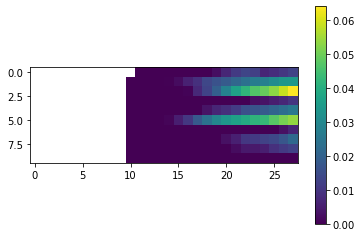

In [118]:
plt.imshow(combined_sli.iloc[[1418, 1618, 1621, 1632, 1633, 1634, 1638, 1641, 1644, 1651]][combined_sli.columns[-428:-400]])
plt.colorbar()

Natural substrate


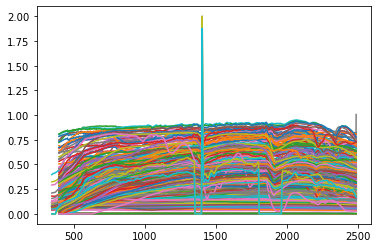

Other man-made


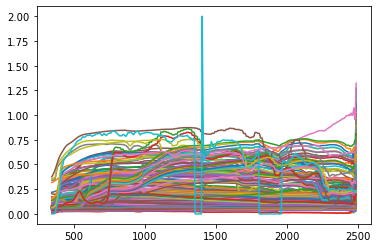

Asphalt


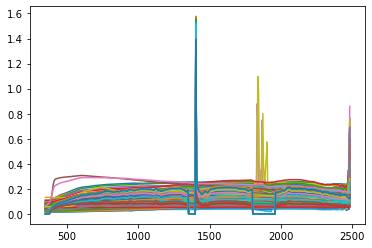

Concrete


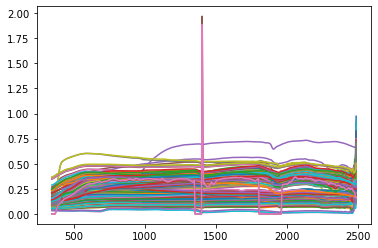

Brick


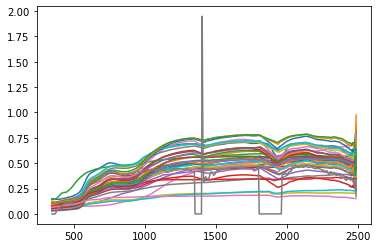

Metal


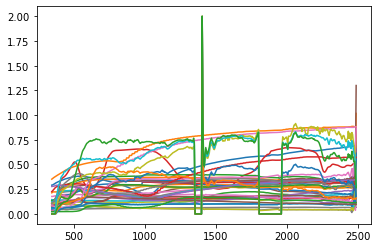

Plastic


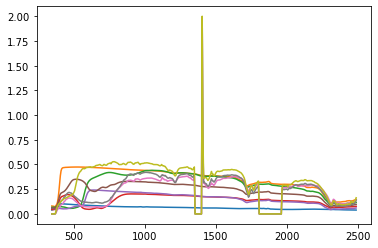

NPV


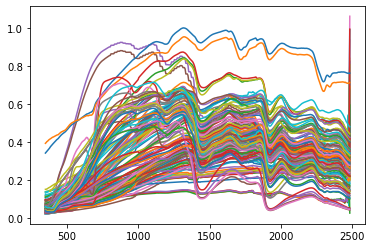

PV


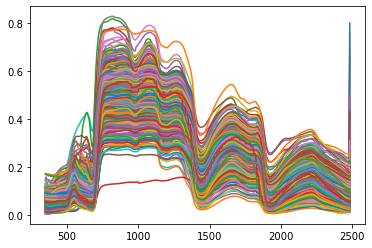

Water


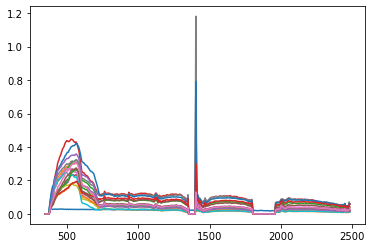

In [111]:
from matplotlib import pyplot as plt

for c in combined_sli["Planet"].unique():
    print(c)
    plt.plot(combined_sli.columns[-428:].astype(float), combined_sli[combined_sli["Planet"]==c][combined_sli.columns[-428:]].T)
    plt.show()